In [22]:
import matplotlib.pyplot as plt
from math import pi
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn

from sklearn import preprocessing, model_selection
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn import metrics
from matplotlib import rcParams
from matplotlib import pyplot
import plotly.express as px
rcParams['axes.titlepad'] = 10

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score


XGBoost model recall score: 0.7784
XGBoost model accuracy score: 0.5809


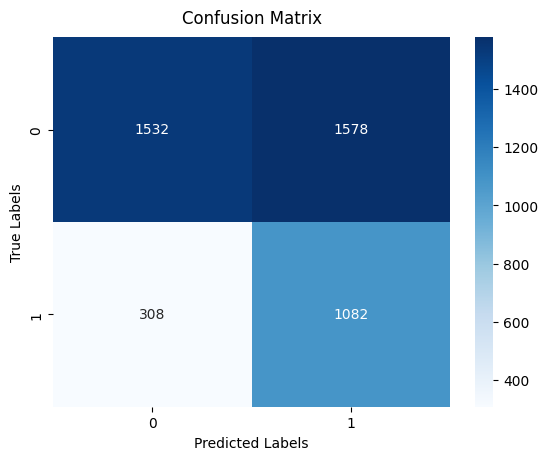

In [23]:
df =pd.read_csv("aids.csv")
df.head()

X = df.drop('infected', axis=1)  
y = df['infected'].astype(int)  # Assicurati che y sia di tipo int (binario)
X_encoded = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=45)

best_params =  {
    'subsample': 0.7, 
    'scale_pos_weight': 3, 
    'reg_lambda': 5, 
    'reg_alpha': 10, 
    'n_estimators': 200, 
    'min_child_weight': 3, 
    'max_depth': 15, 
    'learning_rate': 0.01, 
    'gamma': 0.3, 
    'colsample_bytree': 1.0
    
    }
xgb_clf = XGBClassifier(**best_params)
xgb_clf.fit(X_train, y_train)

# Predizctions on  test set
y_pred = xgb_clf.predict(X_test)

recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print('XGBoost model recall score: {0:0.4f}'.format(recall))
print('XGBoost model accuracy score: {0:0.4f}'.format(accuracy))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [24]:
y_pred = xgb_clf.predict_proba(X_test)

##### Interpretable Machine Learning methods

###### Feature importance

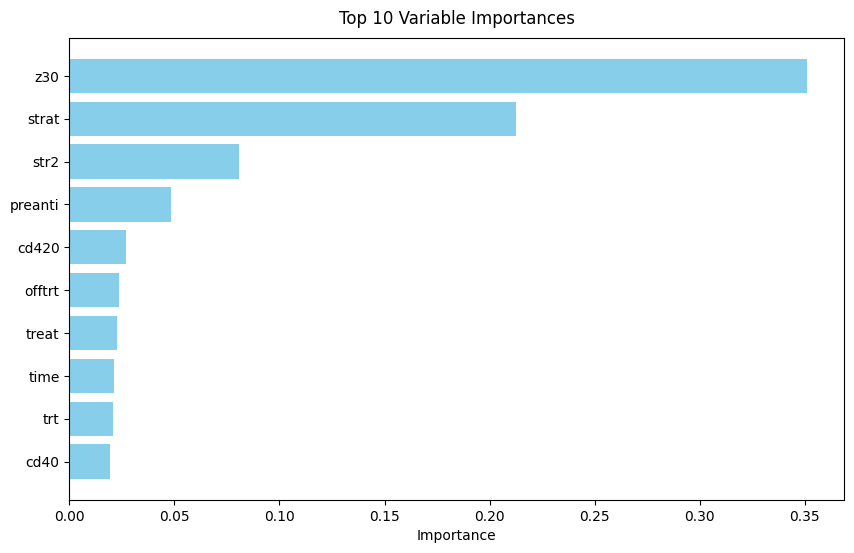

In [25]:
importance = xgb_clf.feature_importances_
features = X_test.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'].head(10), importance_df['Importance'].head(10), color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 Variable Importances')
plt.gca().invert_yaxis() 
plt.show()

###### Permutation feature importance

###### Partial dependence plot

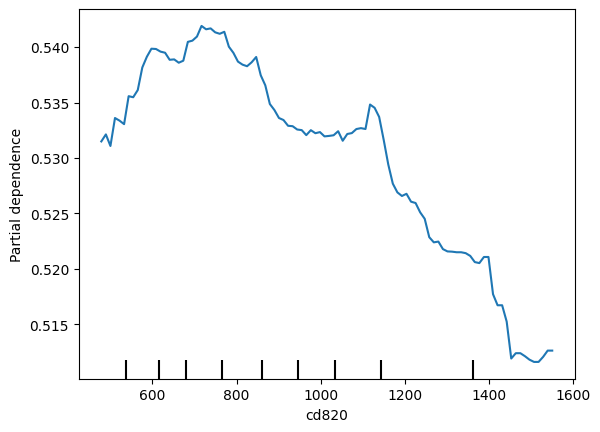

In [26]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(xgb_clf, 
                                        X_test, 
                                        ['cd820'])

###### Accumulated local efffects

PyALE._ALE_generic:INFO: Continuous feature detected.


['time', 'trt', 'age', 'wtkg', 'hemo', 'homo', 'drugs', 'karnof', 'oprior', 'z30', 'preanti', 'race', 'gender', 'str2', 'strat', 'symptom', 'treat', 'offtrt', 'cd40', 'cd420', 'cd80', 'cd820']


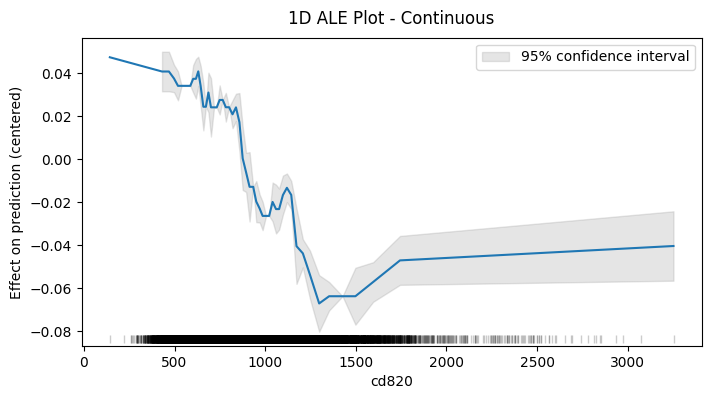

In [27]:
from PyALE import ale

features = X_encoded.columns.tolist()
print(features)
ale_eff = ale(X = X_encoded[features], model = xgb_clf, feature = ['cd820'], grid_size = 50)

###### Individual conditional expectations plot

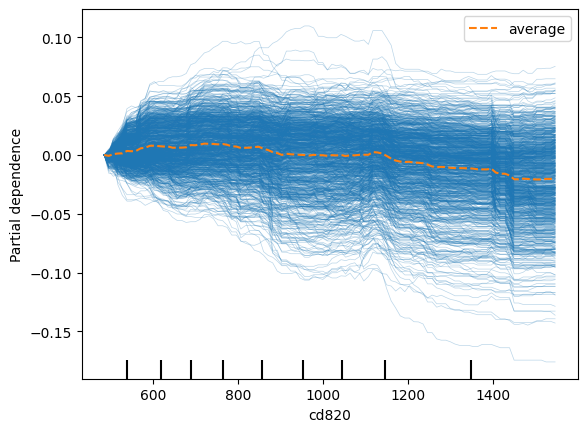

In [28]:
from sklearn.inspection import PartialDependenceDisplay

features_info = {
    "features": ["cd820"],
    "kind": "both",
    "centered": True,
}
PartialDependenceDisplay.from_estimator(
    xgb_clf,
    X_train,
    **features_info
)

###### Shapley values

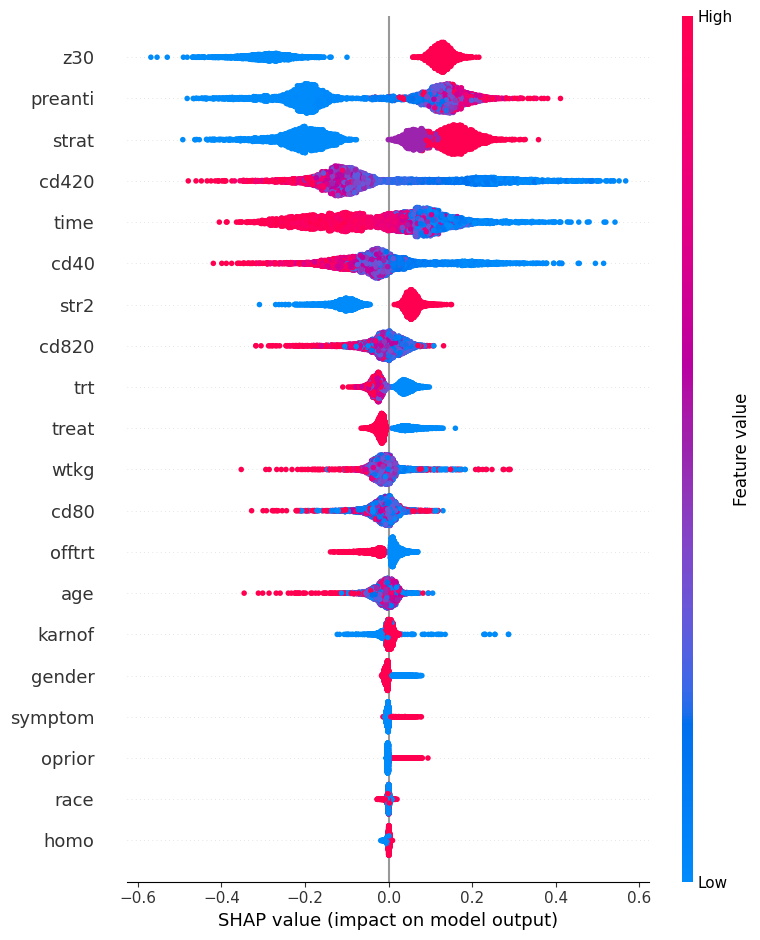

In [37]:
import shap
#Calcolo dei valori SHAP
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer(X_test)
expected_value = explainer.expected_value #valore atteso delle predizioni del modello

# Genera il plot SHAP summary
shap.summary_plot(shap_values, X_test, title="SHAP summary plot")


In [30]:
predictions_proba = xgb_clf.predict_proba(X_test)
positive_class_proba = predictions_proba[:, 1]
# Find TP
true_positive_indices = np.where((positive_class_proba > 0.5) & (y_test == 1))[0]
print("True positives instances:")
print(true_positive_indices)
print("Number of True positives: ",len(true_positive_indices))
# Find FN
false_negatives_indices = np.where((positive_class_proba < 0.5) & (y_test == 1))[0]
print("False negatives instances:")
print(false_negatives_indices)
print("Number of False negatives: ",len(false_negatives_indices))

True positives instances:
[   3    7    9 ... 4491 4494 4499]
Number of True positives:  1082
False negatives instances:
[   8   26   60   63   72   84   97  101  102  134  135  139  157  164
  173  185  191  193  207  215  222  241  246  248  262  285  288  303
  330  358  364  393  394  434  442  450  468  473  492  517  520  524
  539  545  558  572  587  588  596  656  666  674  683  695  699  708
  714  716  727  732  742  745  752  766  792  814  820  830  832  843
  844  849  880  881  884  912  953  970  978  981 1000 1011 1029 1100
 1115 1120 1144 1149 1152 1156 1158 1204 1240 1250 1251 1276 1294 1297
 1311 1321 1323 1353 1360 1375 1376 1410 1413 1420 1432 1464 1469 1554
 1562 1564 1576 1591 1661 1669 1677 1685 1687 1708 1717 1731 1754 1758
 1775 1778 1779 1788 1867 1874 1896 1911 1924 2019 2024 2029 2031 2046
 2060 2072 2074 2078 2083 2085 2096 2099 2111 2114 2134 2139 2161 2162
 2175 2179 2182 2206 2230 2239 2242 2245 2322 2334 2360 2384 2393 2398
 2403 2409 2413 2415 2442 2

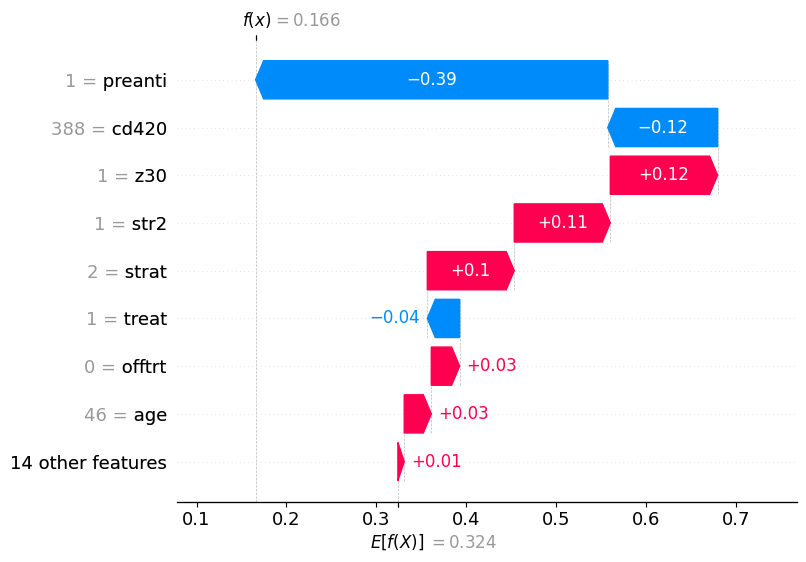

In [38]:
shap.plots.waterfall(shap_values[9], max_display=14)

###### lime

In [43]:
# Assuming xgb_clf is a trained XGBoost classifier
# Ensure xgb_clf.predict_proba is available
try:
    getattr(xgb_clf, 'predict_proba')
except AttributeError:
    raise AttributeError("The XGBoost model must have 'predict_proba' method for LIME explanations.")

# Create LIME explainer
explainer_lime = LimeTabularExplainer(X_test.values,
                                      feature_names=X_test.columns.tolist(),
                                      class_names=['infected'], 
                                      verbose=True, mode='classification')

In [46]:
# Explain instance using predict_proba
exp = explainer_lime.explain_instance(X_test.values[30], xgb_clf.predict_proba, num_features=6)

# Show the explanations in notebook
exp.show_in_notebook(show_table=True)

Intercept 0.46312254050223034
Prediction_local [0.61538013]
Right: 0.73793405


###### anchors

In [51]:
from anchor import anchor_tabular

feature_names = X_test.columns
class_names = [str(cls) for cls in y.unique()]

explainer = anchor_tabular.AnchorTabularExplainer(
    class_names=class_names,
    feature_names=feature_names,
    train_data=X_test.values
)

In [52]:
np.random.seed(2)
sample_to_explain = X_test.iloc[4].values
exp = explainer.explain_instance(sample_to_explain, xgb_clf.predict)

print('Precision: %.2f' % exp.precision())
print('Coverage: %.2f' % exp.coverage())

Precision: 0.95
Coverage: 0.35


In [53]:
exp.show_in_notebook()